## Overview

The standard algorithm to train neural networks is stochastic gradient descent.  Increased performance and faster training
may be achieved by using a learning rate that changes during training.

### Adaptive learning rates

The simplest and perhaps most used adaptation of learning rates during training are techniques 
that reduce the learning rate over time. These have the benefit of making large changes at the 
beginning of the training procedure when larger learning rate values are used, and decreasing 
the learning rate such that a smaller rate and therefore smaller training updates are made to 
weights later in the training procedure. This has the effect of quickly learning good weights 
early and fine tuning them later.  Two of the most popular techniques used are:
- Decrease the learning rate based on the epoch
- Decrease the learning rate using the punctuated large drops at specific epochs

In [9]:
import pandas as pd
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler

### Test Dataset

Test datset used is the Ionosphere binary classification dataset from the well know UCI Machine Learning Repo.  
 - http://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data

The dataset describes radar returns where the target was free electrons in the ionosphere. It is a binary classification problem where positive cases (g for good) show evidence of some type of structure in the ionosphere and negative cases (b for bad) do not. There are 34 attributes and 351 observations.

In [2]:
seed = 7
np.random.seed(7)

url = ("http://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data")
dataset = pd.read_csv(url, header=None, prefix='V')

dataset.head()

X = np.array(dataset.iloc[:, 0:34])
y = np.array(dataset.iloc[:, 34])

### Adaptive rate schedule

The stochastic gradient descent algorithm in Keras *SGD* has a built in decay argument.  This argument is used as:

$$\begin{eqnarray}
Learning Rate = Learning Rate \times \frac{1}{1+decay \times epoch}  
\end{eqnarray}$$

Extending this to 100 epochs would produce the output shown below:

In [3]:
def gen_plot(ans,lim):
    prev = 0.1
    for n in range(0,lim):
        ans[n] = prev * 1/(1+0.001*(n+1))
        prev = ans[n]
    return ans

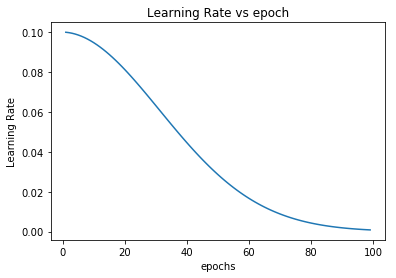

In [4]:
epoch = [n for n in range(1,100)]
ans = [0 for n in range(1,100)] 
ans = gen_plot(ans,len(epoch))    
plt.plot(epoch,ans)
plt.ylabel('Learning Rate')
plt.xlabel('epochs')
plt.title('Learning Rate vs epoch')
plt.show()

A small neural network model is constructed below with a single hidden layer with 34 neurons
and using the rectifier activation function. The output layer has a single neuron and uses the
sigmoid activation function in order to output probability-like values. The learning rate for
stochastic gradient descent has been set to a higher value of 0.1. The model is trained for 50
epochs and the decay argument has been set to LearningRate/Epochs, calculated as 0.1/50. Also it can 
be a good idea to use momentum when using an adaptive learning rate. Here use a momentum value of 0.8.

In [5]:
#encode class labels as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
#create model
model = Sequential()
model.add(Dense(34,input_dim=34,kernel_initializer='normal',activation='relu'))
model.add(Dense(1,kernel_initializer='normal',activation = 'sigmoid'))
#compile model
epochs = 50
learning_rate = 0.1
decay_rate = learning_rate/epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum,decay=decay_rate,nesterov=False)
model.compile(loss='binary_crossentropy',optimizer=sgd,metrics=['accuracy'])
#fit the model
model.fit(X,y,validation_split = 0.33,epochs=epochs,batch_size=28,verbose=2)

Train on 235 samples, validate on 116 samples
Epoch 1/50
 - 0s - loss: 0.6813 - acc: 0.6468 - val_loss: 0.6380 - val_acc: 0.8621
Epoch 2/50
 - 0s - loss: 0.6367 - acc: 0.7319 - val_loss: 0.5265 - val_acc: 0.8276
Epoch 3/50
 - 0s - loss: 0.5571 - acc: 0.8213 - val_loss: 0.4758 - val_acc: 0.8362
Epoch 4/50
 - 0s - loss: 0.4666 - acc: 0.8340 - val_loss: 0.4405 - val_acc: 0.9310
Epoch 5/50
 - 0s - loss: 0.3836 - acc: 0.8681 - val_loss: 0.2768 - val_acc: 0.9483
Epoch 6/50
 - 0s - loss: 0.3156 - acc: 0.8851 - val_loss: 0.3979 - val_acc: 0.8879
Epoch 7/50
 - 0s - loss: 0.2763 - acc: 0.9064 - val_loss: 0.2241 - val_acc: 0.9483
Epoch 8/50
 - 0s - loss: 0.2407 - acc: 0.9106 - val_loss: 0.1432 - val_acc: 0.9569
Epoch 9/50
 - 0s - loss: 0.2439 - acc: 0.9149 - val_loss: 0.2187 - val_acc: 0.9483
Epoch 10/50
 - 0s - loss: 0.2020 - acc: 0.9149 - val_loss: 0.2547 - val_acc: 0.9224
Epoch 11/50
 - 0s - loss: 0.1912 - acc: 0.9277 - val_loss: 0.1950 - val_acc: 0.9397
Epoch 12/50
 - 0s - loss: 0.1722 - acc:

Classification accuracy of 99.14% which is higher than the baseline of 95.69%

## Drop-Based Learning Rate Schedule

Another method is to systematically drop the 
learning rate at specific times during training. Often this method is implemented by dropping the learning
rate by half every fixed number of epochs. For example, we may have an initial learning rate of 0.1 and 
drop it by a factor of 0.5 every 10 epochs. The first 10 epochs of training would use a value of 0.1, in
the next 10 epochs a learning rate of 0.05 would be used, and so on.

In [28]:
# learning rate schedule
def step_decay(lrate,epoch,lim):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    for n in range(0,lim):
        lrate[n] = initial_lrate * math.pow(drop, math.floor((1+epoch[n])/epochs_drop))
    return lrate

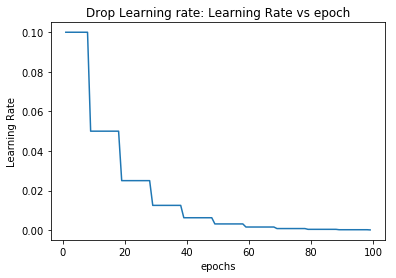

In [30]:
epoch = [n for n in range(1,100)]
lrate = [n for n in range(1,100)]
ans = step_decay(lrate,epoch,len(epoch))    
plt.plot(epoch,ans)
plt.ylabel('Learning Rate')
plt.xlabel('epochs')
plt.title('Drop Learning rate: Learning Rate vs epoch')
plt.show()

We can implement this in Keras using the LearningRateScheduler callback when fitting the model. The LearningRateScheduler callback allows us to define a function to call that takes the epoch number as an argument and returns the learning rate to use in stochastic gradient descent. When used, the learning rate specified by stochastic gradient descent is ignored.
- http://keras.io/callbacks/

In [32]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [33]:
model = Sequential()
model.add(Dense(34,input_dim=34,kernel_initializer='normal',activation='relu'))
model.add(Dense(1,kernel_initializer='normal',activation='sigmoid'))
#compile model
sgd = SGD(lr=0.0,momentum=0.9,decay=0.0,nesterov=False)
model.compile(loss='binary_crossentropy',optimizer=sgd,metrics=['accuracy'])
#learning rate callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
model.fit(X,y,validation_split=0.33,epochs=50,batch_size=28,callbacks=callbacks_list,verbose=2)

Train on 235 samples, validate on 116 samples
Epoch 1/50
 - 0s - loss: 0.6883 - acc: 0.4936 - val_loss: 0.6028 - val_acc: 0.9310
Epoch 2/50
 - 0s - loss: 0.6239 - acc: 0.7319 - val_loss: 0.4716 - val_acc: 0.9052
Epoch 3/50
 - 0s - loss: 0.5217 - acc: 0.8128 - val_loss: 0.4047 - val_acc: 0.9310
Epoch 4/50
 - 0s - loss: 0.3631 - acc: 0.8766 - val_loss: 0.2084 - val_acc: 0.9569
Epoch 5/50
 - 0s - loss: 0.2856 - acc: 0.8809 - val_loss: 0.1773 - val_acc: 0.9569
Epoch 6/50
 - 0s - loss: 0.2182 - acc: 0.9106 - val_loss: 0.1325 - val_acc: 0.9569
Epoch 7/50
 - 0s - loss: 0.2012 - acc: 0.9277 - val_loss: 0.0897 - val_acc: 0.9741
Epoch 8/50
 - 0s - loss: 0.2047 - acc: 0.9191 - val_loss: 0.0912 - val_acc: 0.9741
Epoch 9/50
 - 0s - loss: 0.1702 - acc: 0.9319 - val_loss: 0.2447 - val_acc: 0.9224
Epoch 10/50
 - 0s - loss: 0.1415 - acc: 0.9660 - val_loss: 0.0833 - val_acc: 0.9741
Epoch 11/50
 - 0s - loss: 0.1267 - acc: 0.9489 - val_loss: 0.1683 - val_acc: 0.9655
Epoch 12/50
 - 0s - loss: 0.1130 - acc:

Classification accuracy of 99.14% which is higher than the baseline of 95.69%